In [1]:
import os
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5, style="ticks")

all_results = list()

month="02"

our_model="VaxSeer"

seq_threshold = 0.4 #

output_paths = []
all_dfs = []
model2df = defaultdict(list)
for subtype in ("h3n2", "h1n1"): # "h1n1"):
    for year in range(2012, 2022): # 2022
        domiance_models_map = {
            "history_6M": "Last", 
            "weight_loss_by_count_lightning_logs_version_0": our_model,
            "lm_lightning_logs_version_0": "LM",
            "evescape": "EVEscape",
            "viral_mut_cscs": "CSCS",
        }
        hi_models = {
            "exp_before_%d-%s_blosum" % (year, month): "BLOSUM",
            "aa_subs": "LR+",
            "cnn": "CNN",
            "max_steps_150k": our_model,
        }

        vaccine_scores_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=%d-%s-%d-%s___virus_set=%d-%s-%d-%s/vaccine_scores" % \
                                (year, month, subtype, year-3, month, year, month, year-3, month, year, month)


        for file in os.listdir(vaccine_scores_path):
            model_key = None

            prob_file, exp_file = file.split("___")
            prob_file = prob_file.split("prob=")[1]
            exp_file = exp_file.split("hi=")[1]
            if prob_file in domiance_models_map and exp_file in  hi_models:
                model_key = domiance_models_map[prob_file] + "___" + hi_models[exp_file]
                _df = pd.read_csv(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv"))
                _df["year"] = [str(year)] * len(_df)
                _df["subtype"] = [subtype] * len(_df)
                model2df[model_key].append(_df)

                if model_key == "%s___%s" % (our_model, our_model):
                    df = pd.read_csv(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv"))
                    df["year"] = [str(year)] * len(df)
                    df["subtype"] = [subtype] * len(df)
                    all_dfs.append(df)


for model in model2df:
    model2df[model] = pd.concat(model2df[model])

all_dfs = pd.concat(all_dfs)

result_matrix_seq = []
result_matrix_seq_pvalue = []
# print("Model,Threshold,Clade-R,P,Seq-R,P,#vaccine_clade,#vaccine_seq,Clade-RMSE,Seq-RMSE")
for model in model2df:
    
    mask_seq = ~np.isnan(model2df[model]["gt_score_seq"])
    mask_seq = np.logical_and(mask_seq, model2df[model]["coverage_seq"]>seq_threshold)
    
    spearman_rank_seq, pvalue_seq = stats.spearmanr(model2df[model]["score"][mask_seq], model2df[model]["gt_score_seq"][mask_seq])

    result_matrix_seq.append((model.split("___")[0], model.split("___")[1], spearman_rank_seq))
    result_matrix_seq_pvalue.append((model.split("___")[0], model.split("___")[1], pvalue_seq))

    all_results.append([model, seq_threshold, spearman_rank_seq, pvalue_seq, mask_seq.sum()])

    if model == "%s___%s" % (our_model, our_model):
        our_res_seq = (spearman_rank_seq, pvalue_seq)
        
all_dfs["neg_score"] = -all_dfs["score"]


In [3]:
all_dfs["neg_gt_score_seq"] = -all_dfs["gt_score_seq"]

all_results_df = pd.DataFrame(all_results,
                   columns=["model", "confidence_threshold_seq","Seq-R","Seq-P","#vaccine_seq"])

all_results_df["dominance model"] = [x.split("___")[0] for x in all_results_df["model"]]
all_results_df["hi model"] = [x.split("___")[1] for x in all_results_df["model"]]
all_results_df

,model,confidence_threshold_seq,Seq-R,Seq-P,#vaccine_seq,dominance model,hi model
0,LM___LR+,0.4,0.623220,3.403304e-12,101,LM,LR+
1,CSCS___CNN,0.4,0.663663,3.924997e-14,101,CSCS,CNN
2,VaxSeer___LR+,0.4,0.695143,7.326815e-16,101,VaxSeer,LR+
3,LM___VaxSeer,0.4,0.702109,2.831412e-16,101,LM,VaxSeer
4,LM___BLOSUM,0.4,0.626021,2.550805e-12,101,LM,BLOSUM
5,VaxSeer___VaxSeer,0.4,0.806938,2.262608e-24,101,VaxSeer,VaxSeer
6,EVEscape___CNN,0.4,0.633878,1.118624e-12,101,EVEscape,CNN
7,Last___CNN,0.4,0.699446,4.085990e-16,101,Last,CNN
8,Last___BLOSUM,0.4,0.651211,1.666209e-13,101,Last,BLOSUM
9,CSCS___VaxSeer,0.4,0.668039,2.322972e-14,101,CSCS,VaxSeer


/data/rsg/nlp/wenxian/miniconda3/envs/torchlit/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


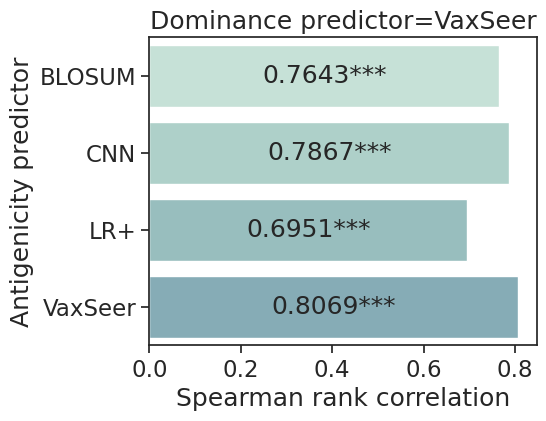

In [4]:
hi_result_matrix = all_results_df[all_results_df["dominance model"] == our_model ]

hi_result_matrix["Seq-R"] = np.asarray(hi_result_matrix["Seq-R"], dtype=np.float32)
hi_result_matrix = hi_result_matrix.sort_values(by=['hi model'], key=lambda col: ["a" + x if x != "our" else "z" + x for x in col.str.lower()])


a4_dims = (5, 4)
fig, ax = plt.subplots(figsize=a4_dims)

ax = sns.barplot(hi_result_matrix, ax=ax,
                 x="Seq-R", 
                 y="hi model", 
                 orient="h", 
                 palette=sns.cubehelix_palette(start=.5, rot=-.5, dark=.5)) # , palette="pastel"
    
for i in ax.containers:
    display_labels = []
    for value, p in zip(hi_result_matrix["Seq-R"], hi_result_matrix["Seq-P"]):
        if p < 0.001:
            display_labels.append("%.4f***" % value)
        elif p < 0.01:
            display_labels.append("%.4f**" % value)
        elif p < 0.05:
            display_labels.append("%.4f*" % value)
        else:
            display_labels.append("%.4f" % value)
    ax.bar_label(i,labels=display_labels, label_type="center")

ax.set_ylabel("Antigenicity predictor")
ax.set_xlabel("Spearman rank correlation")
ax.set_title("Dominance predictor=%s" % ( our_model) )
plt.savefig("figs/main_res_seqs_merged_from_%d_hi.pdf" % (2012), format='pdf', bbox_inches='tight')
plt.show()


/data/rsg/nlp/wenxian/miniconda3/envs/torchlit/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


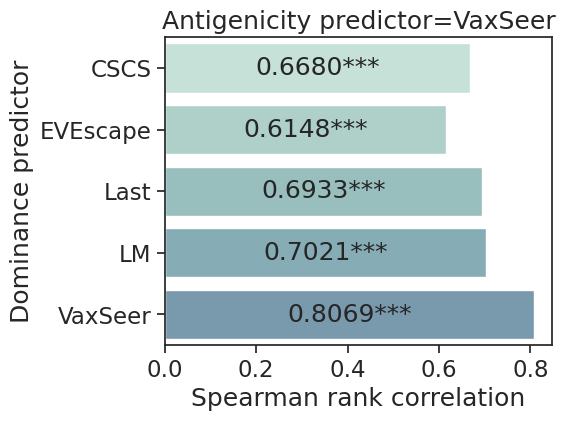

In [5]:

hi_result_matrix = all_results_df[all_results_df["hi model"] == our_model]
hi_result_matrix["Seq-R"] = np.asarray(hi_result_matrix["Seq-R"], dtype=np.float32)
hi_result_matrix = hi_result_matrix[~hi_result_matrix["dominance model"].isin(["gt", "oracle"])]
hi_result_matrix = hi_result_matrix.sort_values(by=['dominance model'], key=lambda col: ["a" + x if x != "our" else "z" + x for x in col.str.lower()])


a4_dims = (5, 4)
fig, ax = plt.subplots(figsize=a4_dims)


ax = sns.barplot(hi_result_matrix, ax=ax, x="Seq-R", y="dominance model", orient="h", palette=sns.cubehelix_palette(start=.5, rot=-.5, dark=.5))

for i in ax.containers:
    display_labels = []
    for value, p in zip(hi_result_matrix["Seq-R"], hi_result_matrix["Seq-P"]):
        if p < 0.001:
            display_labels.append("%.4f***" % value)
        elif p < 0.01:
            display_labels.append("%.4f**" % value)
        elif p < 0.05:
            display_labels.append("%.4f*" % value)
        else:
            display_labels.append("%.4f" % value)
    ax.bar_label(i,labels=display_labels, label_type="center")

ax.set_ylabel("Dominance predictor")
ax.set_xlabel("Spearman rank correlation")
ax.set_title("Antigenicity predictor=%s" % ( our_model ))
plt.savefig("figs/main_res_seqs_merged_from_%d_domiance.pdf" % (2012), format='pdf', bbox_inches='tight')
plt.show()


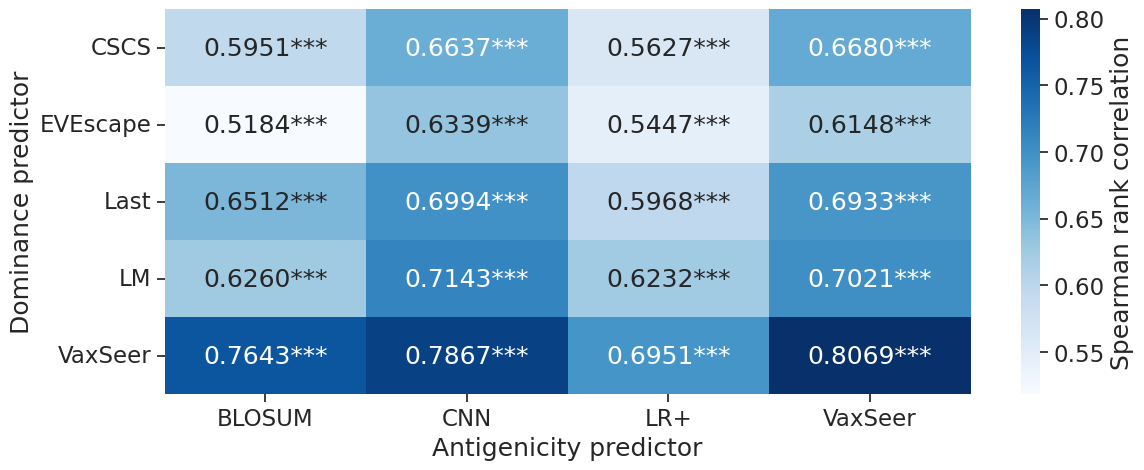

In [6]:

result_matrix = pd.DataFrame(np.array(result_matrix_seq), columns=['dominance predictor', 'hi predictor', 'R'])
result_matrix_seq_pvalue = pd.DataFrame(np.asarray(result_matrix_seq_pvalue), columns=['dominance predictor', 'hi predictor', 'P'])

mm = result_matrix.pivot("dominance predictor", "hi predictor", "R")
mm_pvalue = result_matrix_seq_pvalue.pivot("dominance predictor", "hi predictor", "P")

mm = mm.sort_values(by=['dominance predictor'], key=lambda col: ["a" + x if x != "our" else "z" + x for x in col.str.lower()])
mm_pvalue = mm_pvalue.sort_values(by=['dominance predictor'], key=lambda col: ["a" + x if x != "our" else "z" + x for x in col.str.lower()])

fig, ax = plt.subplots(figsize=(13,5))

annotations = [[""] * mm_pvalue.shape[1] for _ in range(mm_pvalue.shape[0])]
for i in range(mm_pvalue.shape[0]):
    for j in range(mm_pvalue.shape[1]):
#         print(mm_pvalue)
        p = mm_pvalue.to_numpy(float)[i, j]
        value = mm.to_numpy(float)[i, j]
        
        if p < 0.001:
            annotations[i][j] = ("%.4f***" % value)
        elif p < 0.01:
            annotations[i][j] = ("%.4f**" % value)
        elif p < 0.05:
            annotations[i][j] = ("%.4f*" % value)
        else:
            annotations[i][j] = ("%.4f" % value)
            
annotations = np.asarray(annotations)

ax = sns.heatmap(mm.astype(float), annot=annotations, fmt="s", cmap="Blues", cbar_kws={'label': 'Spearman rank correlation'})

ax.set_xlabel("Antigenicity predictor")
ax.set_ylabel("Dominance predictor")

plt.savefig("figs/main_res_seqs_merge_from_%d.pdf" % (2012), format='pdf', bbox_inches='tight')
plt.show()